In [44]:
# === Parsing des fichiers XML ===
from bs4 import BeautifulSoup

# === Préparation de données ===
import pandas as pd
import numpy as np

# === Visualisation ===
import matplotlib.pyplot as plt

# === Traitement de texte ===
import spacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

# === Classification et machine learning ===
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier

# === Évaluation des modèles ===
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# === Autre ===
import prettytable
from prettytable.colortable import ColorTable, Themes
from itertools import product
import time

# TO DO LIST DANS LE NOTEBOOK !

- [x] Finir les codes/graphes et explications de la partie données
- [X] Faire les liens du sommaire
- [x] Finir partie sur les tests de vectorisation
- [ ] Commenter la classe
- [ ] Faire le test
- [ ] Faire le test avec stratégies d'équillibrage
- [ ] Refaire les trois meilleurs modèles avec les données non traitées
- [ ] Faire voting classifier et entrainement trilingue/bilingue
- [ ] Partie évaluation
- [ ] Conclusion

# **Sommaire**

- [1. Présentation des données](#1-présentation-des-données)
    - [A. Extraction des données](#a-extraction-des-données)
    - [B. Suppression des doublons](#b-suppression-des-doublons)
    - [C. Distribution des classes](#c-distribution-des-classes)

- [2. Pré-traitement des données](#2-pré-traitement-des-données)
    - [A. Normalisation des données](#a-normalisation-des-données)
    - [B. Vectorisation des données](#b-vectorisation-des-données)

- [3. Comparaison des modèles](#3-comparaison-des-modèles)
    - [A. Choix des algorithmes](#a-choix-des-algorithmes)
    - [B. Organisation de la comparaison](#b-organisation-de-la-comparaison)

- [4. Stratégies d'amélioration](#4-stratégies-damélioration)

- [5. Évaluation des modèles](#5-évaluation-des-modèles)
    - [A. Métriques d'évaluation](#a-métriques-dévaluation)
    - [B. Analyse des résultats](#b-analyse-des-résultats)

<a id="1-présentation-des-données"></a>
# **1. Présentation des données**

On a installé sur le site du [DEFT 2009](https://deft.lisn.upsaclay.fr/) les données pour réaliser la tâche 3 qui est la suivante :
- **Entraîner un modèle qui détermine automatiquement le parti politique d’appartenance de chaque intervenant dans le corpus parlementaire.**

**Il y a en tout 5 classes qui correspondent aux différents partis politiques :**
| Classe (groupe)      | Orientation politique       | Thématiques principales                                   |
|--------------|-----------------------------|----------------------------------------------------------|
| **Verts-ALE** | Écologistes et régionalistes | Environnement, droits des minorités, économie durable    |
| **GUE/NGL**   | Gauche radicale             | Justice sociale, opposition à l'austérité, droits des travailleurs |
| **PSE**       | Social-démocrates           | Réduction des inégalités, protection sociale, intégration européenne |
| **ELDR**      | Libéraux                   | Libre marché, libertés individuelles, droits de l'homme  |
| **PPE-DE**    | Conservateurs              | Économie sociale de marché, valeurs chrétiennes, sécurité |


Notre corpus est multilingue, c'est-à-dire qu'il contient plusieurs ensembles dans des langues différentes telles que le français, l'anglais et l'italien. C'est donc un corpus parallèle et comparable auquel nous avons affaire. 

<a id="a-extraction-des-données"></a>
## **A. Extraction des données**

Les données que nous avons téléchargées sur le site sont en format **xml**, il va donc nous falloir les parser pour les récolter. Pour cela, nous allons utilisé la librairie **BeautifulSoup**. 
Après avoir ouvert les fichiers et analysé les différentes balises pour pouvoir les extraire : 
- texte 
- id 
- valeur (label)
- confiance (indice de confiance de la catégorisation)

In [45]:
def get_xml_content(file):
    """Cette fonction permet d'extraire le contenu du fichier xml."""

    with open(file, "r") as f:
        soup = BeautifulSoup(f, "xml")
        
    return soup

In [46]:
def extract_train_info(doc):
    """Cette fonction permet d'extraire les données : texte, id, label."""

    doc_dico = {}

    # Extraire l'id
    doc_id = doc.get("id")
    doc_dico["id"] = doc_id

   # Extraire l'évaluation : nombre, valeur (label) et confiance
    evaluation = doc.find("EVALUATION")
    evaluation_parti = evaluation.find("EVAL_PARTI")
    doc_dico["nombre"] = evaluation_parti.get("nombre")

    parti = evaluation_parti.find("PARTI")
    doc_dico["label"] = parti.get("valeur")
    doc_dico["confiance"] = parti.get("confiance")

    # Extraire le texte
    texte = doc.find("p")
    doc_dico["texte"] = texte.text

    return doc_dico

In [47]:
def get_test_labels(file):
    """Cette fonction permet d'extraire les labels de l'ensemble de test à partir des fichiers référence."""
    
    with open(file, "r") as f:
        lines = f.readlines()

    lines = [line.split("\t") for line in lines]
    labels = {line[0]: line[1].strip() for line in lines}

    return labels

En comparant la longueur de la liste de labels et les id des échantillons de test, nous avons pu remarquer que deux interventions ne disposaient pas de label.

In [48]:
labels = get_test_labels("data/ref/deft09_parlement_ref_fr.txt")
for key, value in labels.items():
    if value == "":
        print(key)

1175
4574


Ces deux échantillons ne sont ensuite pas stockés dans la dataframe utilisée pour le reste du TP.

In [49]:
def extract_test_info(doc):
    """Cette fonction permet d'extraire les informations de l'ensemble de test: texte et id."""

    doc_dico = {}

    doc_id = doc.get("id")
    doc_dico["id"] = doc_id

    texte = doc.find("p")
    doc_dico["texte"] = texte.text

    return doc_dico

In [50]:
def get_train_and_test_df(train_file, test_file, ref_file):
    """Cette fonction regroupe les autres ci-dessus et permet d'obtenir nos dataframes train et test."""

    soup_train = get_xml_content(train_file)
    soup_test = get_xml_content(test_file)

    test_labels = get_test_labels(ref_file)

    all_docs = []
    for doc in soup_train.find_all("doc"):
        doc_dico = extract_train_info(doc)
        all_docs.append(doc_dico)
    
    df_train = pd.DataFrame(all_docs)

    all_docs = []
    for doc in soup_test.find_all("doc"):
        doc_dico = extract_test_info(doc)
        if test_labels[doc_dico["id"]] == "": # pour les deux textes sans label dans le fichier de référence
            continue
        doc_dico["label"] = test_labels[doc_dico["id"]]
        all_docs.append(doc_dico)

    df_test = pd.DataFrame(all_docs)
    
    return df_train, df_test

In [51]:
df_train, df_test = get_train_and_test_df("data/train/deft09_parlement_appr_fr.xml", "data/test/deft09_parlement_test_fr.xml", "data/ref/deft09_parlement_ref_fr.txt")

In [52]:
df_train

,id,nombre,label,confiance,texte
0,2_fr:1,1,Verts-ALE,1.00,"Monsieur le Président, j'ai toujours fait preu..."
1,2_fr:2,1,PPE-DE,1.00,"Madame la Présidente, chers collègues, à l'app..."
2,2_fr:3,1,Verts-ALE,1.00,"Je voudrais savoir si l'Union européenne, à la..."
3,2_fr:4,1,PSE,1.00,"Madame la Présidente, au nom des de la commis..."
4,2_fr:5,1,PSE,1.00,"Monsieur le Président, chers collègues, Monsie..."
...,...,...,...,...,...
19365,2_fr:19366,1,PSE,1.00,"Monsieur le Président, je voudrais tout d’abor..."
19366,2_fr:19367,1,PPE-DE,1.00,"Monsieur le Président, Monsieur le Commissaire..."
19367,2_fr:19368,1,PPE-DE,1.00,"Monsieur le Président, je tiens à déclarer, au..."
19368,2_fr:19369,1,PPE-DE,1.00,"Monsieur le Président, l’aide à l’Albanie et à..."


In [53]:
df_test

,id,texte,label
0,1,"Monsieur le Président, l'accès à des médias li...",ELDR
1,2,"Monsieur le Président, j'ai un point de vue di...",GUE-NGL
2,3,"Monsieur le Président, Monsieur le Commissaire...",PPE-DE
3,4,Nous ne pouvons soutenir cette tentative d’éri...,GUE-NGL
4,5,"Monsieur le Président, ce court débat se dérou...",PPE-DE
...,...,...,...
12910,12913,"Monsieur le Président, Madame la Commissaire, ...",PPE-DE
12911,12914,"Monsieur le Président, Monsieur le Commissaire...",PPE-DE
12912,12915,"Madame la Présidente, permettez-moi de m'adres...",ELDR
12913,12916,Grâce à la proposition de directive dont trait...,GUE-NGL


<a id="b-suppression-des-doublons"></a>
## **B. Suppression des doublons**

**Après concertation avec les autres étudiants, nous avons été informées qu'il y avait des doublons entre les ensembles de train et de test.**

In [54]:
train_texts = df_train["texte"].to_list()
test_texts = df_test["texte"].to_list()

In [55]:
def check_copy(train_texts, test_texts):

    num_copy = 0

    for text in train_texts:
        if text in test_texts:
            num_copy += 1

    return num_copy

In [56]:
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Il y a 7813 textes en commun entre les données d'entraînement et de test.


**Après vérification, nous trouvions 7813 doublons entre les deux ensembles, soit plus d'un tiers de l'ensemble de train.**

Nous voulions donc retirer ces doublons tout en essayant de respecter le split originel du corpus de 60% des échantillons pour le train et 40% pour le test.

En effet, lorsque qu'on calcule les pourcentages du split :

In [57]:
def get_distribution(df_train, df_test):

    total_texts = len(df_train) + len(df_test)
    percentage_train = len(df_train) / total_texts * 100
    percentage_test = len(df_test) / total_texts * 100

    return percentage_train, percentage_test

In [58]:
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")

Pourcentage de textes d'entraînement : 60.00%
Pourcentage de textes de test : 40.00%


**Nous voulions donc pouvoir enlever les doublons des deux ensembles de manière à rester proches de ce split originel.**
En effet; retirer tous les doublons de l'ensemble de train nous donnerait un split bien trop proche.

In [59]:
def balance_distribution(df_train, df_test):
    """Cette fonction permet de retirer des doublons soit de l'ensemble de train soit de celui de test
    de manière alternée afin de rester le plus proche d'une distribution 60/40."""

    train_texts = df_train["texte"].to_list()
    test_texts = df_test["texte"].to_list()

    for text in train_texts:
        if text in test_texts:
            percentage_train, percentage_test = get_distribution(df_train, df_test)
            difference_train = abs(percentage_train - 60)
            difference_test = abs(percentage_test - 40)

            if difference_train > difference_test:
                df_test = df_test[df_test["texte"] != text]
            else:
                df_train = df_train[df_train["texte"] != text]

    return df_train, df_test

In [60]:
df_train, df_test = balance_distribution(df_train, df_test)
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")

Pourcentage de textes d'entraînement : 53.40%
Pourcentage de textes de test : 46.60%


**Après avoir retirer les doublons, nous nous retrouvons avec un split de 53 pour letrain et 46 pour le test.**

In [61]:
train_texts = df_train["texte"].to_list()
test_texts = df_test["texte"].to_list()
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Il y a 0 textes en commun entre les données d'entraînement et de test.


Après vérification, nous avons bien retiré tous les doublons !

Nous n'avons plus de doublons mais nous restons quelque peu éloignés de la distribution 60/40. **On va donc retirer des textes de l'ensemble de test pour arriver à la distribution souhaitée.**

In [62]:
def reach_desired_distribution(df_train, df_test):

    while True:
        percentage_train, percentage_test = get_distribution(df_train, df_test)

        if percentage_train >= 60:
            break
        else:
            df_test = df_test.drop(df_test.index[0])

    
    return df_train, df_test

In [63]:
df_train, df_test = reach_desired_distribution(df_train, df_test)
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Pourcentage de textes d'entraînement : 60.00%
Pourcentage de textes de test : 40.00%
Il y a 0 textes en commun entre les données d'entraînement et de test.


**Nous arrivons ici à un split fidèle à celui d'origine et à un corpus sans doublon entre les ensembles de train et de test !**

In [64]:
# df_train.to_csv("data/train.csv", index=False)
# df_test.to_csv("data/test.csv", index=False)

<a id="c-distribution-des-classes"></a>
## **C. Distribution des classes**

Nous voulons ici nous intéresser aux distributions de nos classes dans le corpus.

In [65]:
def preparer_distributions_classes(df_train, df_test):
    """Cette fonction permet d'isoler les comptes de chaque classe pour chaque ensemble"""

    train_counts = df_train["label"].value_counts()
    test_counts = df_test["label"].value_counts()

    classes = list(set(train_counts.index).union(set(test_counts.index)))
    train_values = np.array([train_counts.get(cls, 0) for cls in classes])
    test_values = np.array([test_counts.get(cls, 0) for cls in classes])

    return classes, train_values, test_values

In [66]:
prettytable_test_pourcentage = ColorTable(theme=Themes.LAVENDER)
prettytable_test_pourcentage.field_names = ["Classe", "Train", "Test", "Pourcentage"]

def tableau_test_pourcentage(df_train, df_test):
    """Cette fonction permet d'obtenir la répartition de chaque classe entre les deux ensembles.
    Donc de voir combien de pourcentages de chaque classe se retrouve dans l'ensemble de test."""

    classes, train_values, test_values = preparer_distributions_classes(df_train, df_test)

    pourcentage_test = ((test_values / (test_values + train_values)) * 100)
    pourcentage_test = np.nan_to_num(pourcentage_test) 

    for cls, train, test, pourcentage in zip(classes, train_values, test_values, pourcentage_test):
        prettytable_test_pourcentage.add_row([cls, train, test, f"{pourcentage:.2f}%"])
    
    total_train = np.sum(train_values)
    total_test = np.sum(test_values)
    pourcentage_global = (total_test / (total_train + total_test)) * 100

    title = "Pourcentage de la part du test"
    print(f"{title}\n" + "=" * len(title))
    print(prettytable_test_pourcentage)
    print("\nRésumé des totaux\n" + "=" * len("Résumé des totaux"))
    print(f"Total Train : {total_train}")
    print(f"Total Test  : {total_test}")
    print(f"Pourcentage Global Test : {pourcentage_global:.2f}%")
    
tableau_test_pourcentage(df_train, df_test)

Pourcentage de la part du test
+-----------+-------+------+-------------+
|   Classe  | Train | Test | Pourcentage |
+-----------+-------+------+-------------+
|    PSE    |  3650 | 2489 |    40.54%   |
|    ELDR   |  1351 | 908  |    40.19%   |
| Verts-ALE |  1609 | 1072 |    39.99%   |
|   PPE-DE  |  4635 | 3047 |    39.66%   |
|  GUE-NGL  |  1823 | 1196 |    39.62%   |
+-----------+-------+------+-------------+

Résumé des totaux
Total Train : 13068
Total Test  : 8712
Pourcentage Global Test : 40.00%


**Ci-dessus, nous pouvons premièrement voir que chaque classe est splité en 60/40 entre les deux ensembles !**

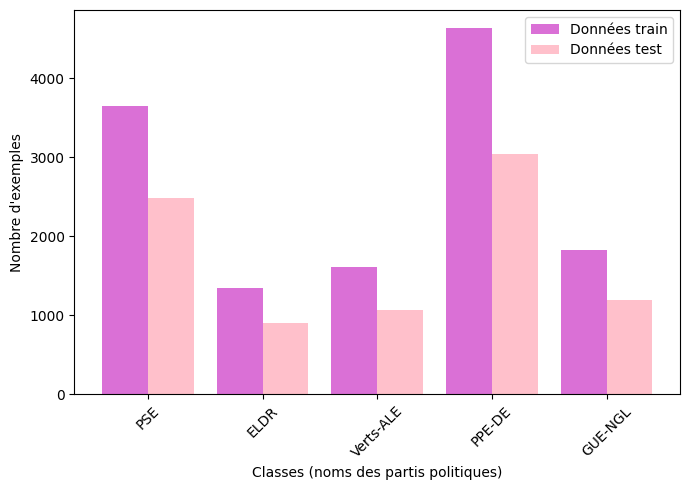

In [67]:
def distribution_des_classes(df_train, df_test):
    """Cette fonction permet d'afficher le nombre d'échantillons de chaque classe dans les deux ensembles."""

    classes, train_values, test_values = preparer_distributions_classes(df_train, df_test)

    x = np.arange(len(classes))
    width = 0.4

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(x - width/2, train_values, width, label="Données train", color="orchid")
    ax.bar(x + width/2, test_values, width, label="Données test", color="pink")

    ax.set_xlabel("Classes (noms des partis politiques)")
    ax.set_ylabel("Nombre d'exemples")
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.savefig("article/graphique_avant.png", dpi=300, bbox_inches="tight")
    plt.show()

distribution_des_classes(df_train, df_test)

**Nous pouvons ici voir comment les classes sont distribuées dans les deux ensembles les unes par rapport aux autres !**
Nous avons des classes clairement majoritaires.

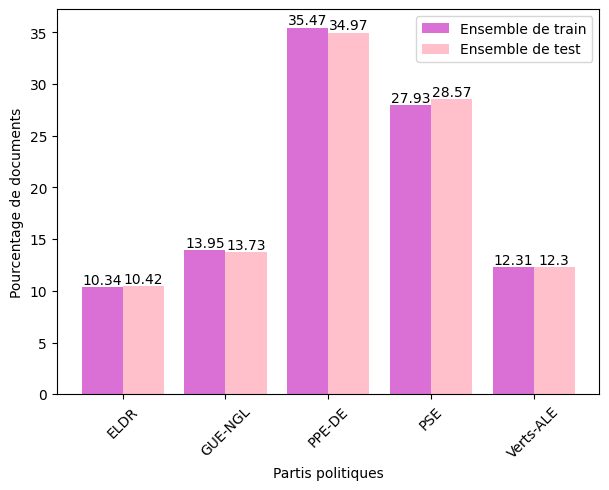

In [68]:
def compare_class_distribution(df_train, df_test):

    total_train = len(df_train)
    total_test = len(df_test)

    train_distribution = {source: count / total_train * 100 for source, count in df_train.groupby("label").size().to_dict().items()}
    test_distribution = {source: count / total_test * 100 for source, count in df_test.groupby("label").size().to_dict().items()}

    x = np.arange(len(train_distribution))
    width = 0.4
    plt.figure(figsize=(7, 5))
    train_bars = plt.bar(x - 0.2, train_distribution.values(), width, label="Ensemble de train", color="orchid")
    test_bars = plt.bar(x + 0.2, test_distribution.values(), width, label="Ensemble de test", color="pink")

    for bar in train_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha="center", va="bottom")

    for bar in test_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha="center", va="bottom")

    plt.xticks(x, train_distribution.keys(), rotation=45)
    plt.xlabel("Partis politiques")
    plt.ylabel("Pourcentage de documents")
    plt.legend()
    plt.savefig("article/graphique_apres.png", dpi=300, bbox_inches="tight")
    plt.show()

compare_class_distribution(df_train, df_test)


**Nous pouvons obtenir les mêmes chiffres mais sous forme de pourcentage afin de voir si la répartition des classes est identique entre les deux ensembles et c'est le cas, notamment car les classes sont splitées en 60/40 de manière égalitaire.**

Dans la description de la tâche, les nombres d'échantillons sont explicités comme étant les suivants :


||   ELDR    | GUE/NGL | PPE-DE     | PSE | Verts/ALE
|:---| :---        |    :----   |          :--- | :--- | :--- |
|Nombre de documents| 3 346 | 4 482   |  11 429 | 9 066 | 3 961 |
|Pourcentage de documents|10.33%|13.84%|35.29%|27.99%|12.23%|

**Lorsqu'ils sont convertis en pourcentage, nous pouvons voir qu'ils semblent correspondre à ceux obtenus après notre équillibrage. Nous avons donc un corpus plus petit que celui original mais semblant disposer des mêmes "conditions" que ce dernier !**

<a id="2-pré-traitement-des-données"></a>
# **2. Pré-traitement des données**

<a id="a-normalisation-des-données"></a>
## **A. Normalisation des données**

Nous allons normaliser nos données en enlevant les ponctuations, stopwords, majuscules et en lemmatisant les textes.

In [69]:
!python -m spacy download en_core_web_sm

     l     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/12.8 MB ? eta -:--:--━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/12.8 MB 2.6 MB/s eta 0:00:05━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/12.8 MB 7.7 MB/s eta 0:00:02━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/12.8 MB 11.2 MB/s eta 0:00:02━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/12.8 MB 11.3 MB/s eta 0:00:01━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/12.8 MB 11.3 MB/s eta 0:00:01━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/12.8 MB 9.4 MB/s eta 0:00:02━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/12.8 MB 10.3 MB/s eta 0:00:02━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/12.8 MB 11.1 MB/s eta 0:00:01━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/12.8 MB 11.8 MB/s eta 0:00:01━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/12.8 MB 11.9 MB/s eta 0:00:01━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/12.8 MB 12.1 MB/s eta 0:00:01━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/12.8 MB 12.1 MB/s eta 0:00:01━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━

In [70]:
nlp = spacy.load("en_core_web_sm")

In [71]:
def tokenize(text):

    doc = nlp(text)
    return doc

In [72]:
def lemmatisation(doc):
    
    return " ".join([token.lemma_ for token in doc])

In [73]:
def i_love_lowercase(text):
    
    return text.lower()

In [74]:
def remove_stop_words(doc):
    
    stop_words = [
    'au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en',
    'et', 'eux', 'il', 'je', 'la', 'le', 'leur', 'lui', 'ma', 'mais', 'me',
    'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou',
    'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur',
    'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous',
    'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées',
    'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est',
    'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez',
    'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais',
    'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes',
    'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses',
    'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes',
    'ayants', 'aie', 'aies', 'ait', 'ayons', 'ayez', 'aient', 'eut', 'eue',
    'eues', 'eus', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons',
    'aurez', 'auront', 'aurais', 'aurait', 'aurions', 'auriez', 'auraient',
    'avais', 'avait', 'avions', 'aviez', 'avaient', 'eut', 'eûmes', 'eûtes',
    'eurent', 'aie', 'aies', 'ait', 'ayons', 'ayez', 'aient', 'eusse',
    'eusses', 'eût', 'eussions', 'eussiez', 'eussent'
    ]

    
    filtered_text = [token for token in doc if token.text not in stop_words]

    return filtered_text

In [75]:
def remove_punctuation(text):

    text = re.sub(r"[^\w\s]", "", text)
    
    return text

In [33]:
def get_beautiful_clean_text(text):

    text = i_love_lowercase(text)
    doc = tokenize(text)
    doc = remove_stop_words(doc)
    text = lemmatisation(doc)
    text = remove_punctuation(text)
   
    return text

df_train["texte_nettoyé"] = df_train["texte"].map(get_beautiful_clean_text)
df_test["texte_nettoyé"] = df_test["texte"].map(get_beautiful_clean_text)

In [34]:
# df_train.to_csv("data/train.csv", index=False)
# df_test.to_csv("data/test.csv", index=False)


In [35]:
# df_train = pd.read_csv("data/train.csv")
# df_test = pd.read_csv("data/test.csv")

In [ ]:
df_train["texte_nettoyé"][1]

'madame présidente  cher collègue  lapproche moment plus sombre lannée  réjouissant dévoquer lété lheure dété  voudrais cependant attirer lattention rituel réglage montre répète chaque printemp chaque automne do not lutilité divise le opinion  jai contacté éleveurs bétail soulignent quil important dassurer bien  être vaches laitière   déjà production laitière  sérénité ruminants troublée maladie vache folle  faudrait accroître stress perturbant rythme habituel  les vaches  changement rythme prend jour deux  autre difficulté existe agriculture  automne  pendant les battage  lheure indique lhumidité matinale devrait avoir disparu  or surprise  nature conforme directive  outre rythme naturel animaux  dynamisme hommes  dépend partiellement luminosité  également perturbé  cause problème supplémentaire '

<a id="b-vectorisation-des-données"></a>
## **B. Vectorisation des données**

**Dans l'article [Forest, D. (2009)](https://www.crihn.org/publications/impacts-de-la-variation-du-nombre-de-traits-discriminants-sur-la-categorisation-des-documents/), on voit que les paramètres de la vectorisation jouent un rôle assez important dans les performances d'une modèle.**

En nous basant sur cet article et sur le TP1, nous allons tester le TFIDF Vectorizer avec différents hyperparamètres sur trois classifieurs différents afin de voir si nous obtenons des résultats significativement mieux. Les classifieurs utilisés seront :
- **KNN** (car utilisé dans l'article)
- **SVC Lineaire** (modèle linéaire)
- **Complement NB** (modèle probabilistique)

Si pour tous ces algorithmes, une vectorisation donne de meilleurs résultats, alors nous utiliserons cette dernières pour le reste de nos tests.

### **Nous commençons par stocker plusieurs vectorizers tfidf avec des hyperparamètres différents.**

In [37]:
vectorizers = {
    "TfidfVectorizer": {
        "model": TfidfVectorizer(),
        "hyperparameters": {
            "max_df": [0.5, 0.9], # ça c'est pour ignorer les mots qui appraîssent dans 0.5 ou 0.9 des documents #defaut = 1
            "max_features": [1000, 15000], # ça c'est pour limiter le nombre de mots à 1000 ou 2000 #defaut = None
            "ngram_range": [(1, 1), (1, 2)], # ça c'est pour prendre en compte les unigrammes ou les bigrammes #defaut = (1, 1)
        }
    }
}

In [38]:
def hyperparameter_vectorizer(vectorizers):
    """Cette fonction permet de lister tous les vectorizes obtenus en combinant tous 
    les hyperparamètres donnés dans le dictionnaire de vectorizers."""

    param_grid = vectorizers["hyperparameters"]
    list_vectorizers = []


    if len(param_grid) == 1:
        param_name, param_values = list(param_grid.items())[0]
        for i, value in enumerate(param_values, start=1):
            params = {param_name: value}
            vectorizer = vectorizers["model"].__class__(**params) 
            list_vectorizers.append(vectorizer)

    else:
        param_grid_combinations = list(product(*param_grid.values()))
        for i, combination in enumerate(param_grid_combinations, start=1):
            params = {param_name: value for param_name, value in zip(param_grid.keys(), combination)}
            vectorizer = vectorizers["model"].__class__(**params) 
            list_vectorizers.append(vectorizer)

    return list_vectorizers

IndentationError: unindent does not match any outer indentation level (<string>, line 3)

In [39]:
list_vectorizers = hyperparameter_vectorizer(vectorizers["TfidfVectorizer"])
list_vectorizers

[TfidfVectorizer(max_df=0.5, max_features=1000),
 TfidfVectorizer(max_df=0.5, max_features=1000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.5, max_features=15000),
 TfidfVectorizer(max_df=0.5, max_features=15000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=1000),
 TfidfVectorizer(max_df=0.9, max_features=1000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=15000),
 TfidfVectorizer(max_df=0.9, max_features=15000, ngram_range=(1, 2))]

**Nous testons donc 8 vectorisers.**

### **Nous vectorisons nos données et stockons ces dernières dans une dataframe pour faciliter les tests sur nos trois algorithmes.**

In [40]:
def store_vectorisations(list_vectorizers, x_train, x_test):
    """Cette fonction permet d'itérer une liste de vectorizers et de vectoriser les données pour ensuite les stocker 
    dans une dataframe."""

    all_vectorisations = []

    for i, vectorizer in enumerate(list_vectorizers):
        x_train_vectorized = vectorizer.fit_transform(x_train)
        x_test_vectorized = vectorizer.transform(x_test)
        all_vectorisations.append({"vectorizer_id": vectorizer.__class__.__name__ + str(i),
                                   "vectorizer": vectorizer, 
                                   "x_train": x_train_vectorized, 
                                   "x_test": x_test_vectorized})
    
    df_vectorisations = pd.DataFrame(all_vectorisations)

    return df_vectorisations

In [41]:
df_vectorisations = store_vectorisations(list_vectorizers, df_train["texte_nettoyé"], df_test["texte_nettoyé"])

In [42]:
df_vectorisations.head()

,vectorizer_id,vectorizer,x_train,x_test
0,TfidfVectorizer0,"TfidfVectorizer(max_df=0.5, max_features=1000)",<Compressed Sparse Row sparse matrix of dtype ...,<Compressed Sparse Row sparse matrix of dtype ...
1,TfidfVectorizer1,"TfidfVectorizer(max_df=0.5, max_features=1000,...",<Compressed Sparse Row sparse matrix of dtype ...,<Compressed Sparse Row sparse matrix of dtype ...
2,TfidfVectorizer2,"TfidfVectorizer(max_df=0.5, max_features=15000)",<Compressed Sparse Row sparse matrix of dtype ...,<Compressed Sparse Row sparse matrix of dtype ...
3,TfidfVectorizer3,"TfidfVectorizer(max_df=0.5, max_features=15000...",<Compressed Sparse Row sparse matrix of dtype ...,<Compressed Sparse Row sparse matrix of dtype ...
4,TfidfVectorizer4,"TfidfVectorizer(max_df=0.9, max_features=1000)",<Compressed Sparse Row sparse matrix of dtype ...,<Compressed Sparse Row sparse matrix of dtype ...


In [43]:
# df_vectorisaions_raw_text = store_vectorisations(list_vectorizers, df_train["texte"], df_test["texte"])

### On peut ensuite itérer à travers ces colonnes et utiliser chaque vectorisation pour entraîner nos classifieurs !

In [44]:
def classic_classifier_function(classifier, df_vectorisations, y_train, y_test):

    model = classifier
    scores = []

    for i, row in df_vectorisations.iterrows():
        vectorizer_id = row["vectorizer_id"]
        vectorizer = row["vectorizer"]
        x_train = row["x_train"]
        x_test = row["x_test"]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        scores.append({"vectorizer": vectorizer, "vectorizer_id" : vectorizer_id, "scores": report})
                      
    return scores


In [45]:
def comparison_vectorisation(df_vectorisations, y_train, y_test):

    print("Test avec knn...")
    scores_knn = classic_classifier_function(KNeighborsClassifier(), df_vectorisations, y_train, y_test)
    print("Test avec cnb...")
    scores_cnb = classic_classifier_function(ComplementNB(), df_vectorisations, y_train, y_test)
    print("Test avec svc...")
    scores_svc = classic_classifier_function(LinearSVC(), df_vectorisations, y_train, y_test)


    sorted_scores_knn = sorted(scores_knn, key=lambda x: x["scores"]["macro avg"]["f1-score"], reverse=True)
    sorted_scores_cnb = sorted(scores_cnb, key=lambda x: x["scores"]["macro avg"]["f1-score"], reverse=True)
    sorted_scores_svc = sorted(scores_svc, key=lambda x: x["scores"]["macro avg"]["f1-score"], reverse=True)

    return sorted_scores_knn, sorted_scores_cnb, sorted_scores_svc

In [46]:
sorted_scores_knn, sorted_scores_cnb, sorted_scores_svc = comparison_vectorisation(df_vectorisations, df_train["label"], df_test["label"])
print(sorted_scores_knn)
print(sorted_scores_cnb)
print(sorted_scores_svc)

Test avec knn...
Test avec cnb...
Test avec svc...
[{'vectorizer': TfidfVectorizer(max_df=0.9, max_features=15000, ngram_range=(1, 2)), 'vectorizer_id': 'TfidfVectorizer7', 'scores': {'ELDR': {'precision': 0.15621301775147928, 'recall': 0.14537444933920704, 'f1-score': 0.15059897318881918, 'support': 908.0}, 'GUE-NGL': {'precision': 0.2858354537743851, 'recall': 0.2817725752508361, 'f1-score': 0.28378947368421054, 'support': 1196.0}, 'PPE-DE': {'precision': 0.4075227599425012, 'recall': 0.5582540203478832, 'f1-score': 0.4711258828417117, 'support': 3047.0}, 'PSE': {'precision': 0.35707456978967494, 'recall': 0.30012053033346725, 'f1-score': 0.32612966601178783, 'support': 2489.0}, 'Verts-ALE': {'precision': 0.1966824644549763, 'recall': 0.07742537313432836, 'f1-score': 0.1111111111111111, 'support': 1072.0}, 'accuracy': 0.3443526170798898, 'macro avg': {'precision': 0.2806656531426034, 'recall': 0.2725893896811444, 'f1-score': 0.26855102136752806, 'support': 8712.0}, 'weighted avg': {'

In [47]:
def fill_vect_table(best_scores, algo, table):

    for score in best_scores:
        vectorizer = score["vectorizer"]
        vectorizer_id = score["vectorizer_id"]
        for metric, value in score["scores"].items():
            if metric == "accuracy":
                accuracy = value
            elif metric == "macro avg":
                macro_f1 = value["f1-score"]
                precision = value["precision"]
                recall = value["recall"]
            
        table.add_row([algo, vectorizer, vectorizer_id, macro_f1, accuracy, precision, recall])

    print(table)
    return table


In [48]:
def visualise_vect_comparison(scores_knn, scores_cnb, scores_svc):

    field_names = ["Algo", "Vectorizer", "Vectorizer ID", "Macro f1", "Accuracy", "Precision", "Rappel"]

    prettytable_knn = ColorTable(theme=Themes.LAVENDER)
    prettytable_knn.field_names = field_names
    prettytable_cnb = ColorTable(theme=Themes.LAVENDER)
    prettytable_cnb.field_names = field_names
    prettytable_svc = ColorTable(theme=Themes.LAVENDER)
    prettytable_svc.field_names = field_names

    three_best_knn = scores_knn[:3]
    three_best_cnb = scores_cnb[:3]
    three_best_svc = scores_svc[:3]

    fill_vect_table(three_best_knn, "knn", prettytable_knn)
    fill_vect_table(three_best_cnb, "cnb", prettytable_cnb)
    fill_vect_table(three_best_svc, "svc", prettytable_svc)


visualise_vect_comparison(sorted_scores_knn, sorted_scores_cnb, sorted_scores_svc)
    

+------+---------------------------------------------------------------------+------------------+---------------------+--------------------+--------------------+--------------------+
| Algo |                              Vectorizer                             |  Vectorizer ID   |       Macro f1      |      Accuracy      |     Precision      |       Rappel       |
+------+---------------------------------------------------------------------+------------------+---------------------+--------------------+--------------------+--------------------+
| knn  | TfidfVectorizer(max_df=0.9, max_features=15000, ngram_range=(1, 2)) | TfidfVectorizer7 | 0.26855102136752806 | 0.3443526170798898 | 0.2806656531426034 | 0.2725893896811444 |
| knn  | TfidfVectorizer(max_df=0.5, max_features=15000, ngram_range=(1, 2)) | TfidfVectorizer3 |  0.2650441027377971 | 0.3410238751147842 | 0.2770092429331589 | 0.2689486431926499 |
| knn  |           TfidfVectorizer(max_df=0.5, max_features=15000)           | TfidfV

**Au vu de nos résultats**, on peut admettre que c'est un tfidf avec une max df de 0.9, des max_features de 15 000 et un ngram range de (1, 2) qui donne les meilleurs résultats.
**Nous utiliserons ainsi cette combinaison d'hyperparamètres et donc cette vectorisation pour nos essais suivants.**

**On peut donc créer les variables que nous utiliserons lors de la suite du TP :**

# ON UTILISE CELLES LÀ

In [49]:
# df_vectorisations["vectorizer"] = df_vectorisations["vectorizer"].str.strip()

best_data = df_vectorisations[df_vectorisations["vectorizer_id"] == "TfidfVectorizer7"]
x_train = best_data.iloc[0]["x_train"]
y_train = df_train["label"]

x_test = best_data.iloc[0]["x_test"]
y_test = df_test["label"]


- x_train
- y_train
- x_test
- y_test

<a id="3-comparaison-des-modèles"></a>
# **3. Comparaison des modèles**

# OK LES GURLIES À FAIRE !

On a le code pour entrainer nos modèles et obtenir des informations (les attributs de la classe) !


Je pense que le mieux right now c'est de garder genre 10 algorithmes dans le dico, commentez les arbres et le LGBM et le SVC de base.

Comme ça vous pouvez modifier la classe ou tester des trucs (si vous voulez) rapidos et sans attendre 20min.

Bref vu que c'est rapidos. On s'en fout un peu des résultats.
Juste obtenir les résultats permet ensuite de passer à la partie 4 qu'il faut finir aujourd'hui !!!

Testez les codes sur les meilleurs algo obtenus avec cette partie comme ça tout va bien.

In [50]:
def time_function(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        return result, end - start
    return wrapper

# ALIX METS MACRO AVG DANS LES ATTRIBUTS !!! VOILA ON A CLASSIFICATION MAIS GO METTRE MACRO AVG

In [51]:
class Model:

    # Contient tous les modèles entrainés ! 
    all_models = []

    def __init__(self, name: str, model=None, scores={}, running_time=None):
        self.name = name
        self.model = model
        self.scores = scores
        self.running_time = running_time

        Model.all_models.append(self)
        # Pour chaque modèle entraîné, on garde son nom (algo + num), le modèle et ses 
        # hyperparamètres pour cet entraînement, les métriques obtenues, et son temps d'execution !

    # Pour vider la liste si nécessaire ! 
    @classmethod
    def reset(cls):
        cls.all_models = []

    # Entraîne le modèle
    @time_function
    def fit_model(self, x_train, y_train):
        self.model.fit(x_train, y_train)
    
    # Prédictions et scores
    @time_function
    def predict(self, x_test, y_test):
        y_pred = self.model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_dict =  {"accuracy": accuracy, **report}
        self.scores = accuracy_dict
        return y_pred

    # Lance les fonctions d'entraînement et de prédiction
    # Stock les temps d'execution
    def test_model(self, x_train, y_train, x_test, y_test):
        _, fit_execution_time = self.fit_model(x_train, y_train)
        y_pred, predict_execution_time = self.predict(x_test, y_test)
        self.running_time = fit_execution_time + predict_execution_time

In [62]:
Model.reset()

In [61]:
from sklearn.linear_model import PassiveAggressiveClassifier

# on met les hyperparamètres par défaut
models_dict = {
    # "LogisticRegression": {"model": LogisticRegression(), "hyperparameters": {"C": [0.5, 1.0]}},
    # # "SGDClassifier": {"model": SGDClassifier(), "hyperparameters": {"alpha": [0.0001, 0.001, 0.01], "loss": ["hinge", "squared_hinge"]}},
    "LinearSVC": {"model": LinearSVC(), "hyperparameters": {"C": [0.5, 1.0], "dual":[True, False]}},
    "RandomForestClassifier": {"model": RandomForestClassifier(), "hyperparameters": {"max_depth": [100]}},
    "KNeighborsClassifier": {"model": KNeighborsClassifier(), "hyperparameters": {"algorithm": "auto", "leaf_size": 30, "metric": "minkowski", "metric_params": None, "n_jobs": None, "n_neighbors": 5," p": 2, "weights": "uniform"}},
    "PassiveAggressiveClassifier": {"model": PassiveAggressiveClassifier(), "hyperparameters": {"max_iter": 1000, "validation_fraction": 0.1, "n_iter_no_change": 5, "shuffle": True, "verbose": 0, "loss": "hinge", "n_jobs": None, "random_state": None, "warm_start": False, "class_weight": None}},
    "MultinomialNB": {"model": MultinomialNB(), "hyperparameters": {"alpha":1.0, "class_prior": None, "fit_prior": True,}},
    "ComplementNB": {"model": ComplementNB(), "hyperparameters": {"alpha": 1.0, "class_prior": None, "fit_prior": True, "norm": False}},
    "SVC": {"model": SVC(), "hyperparameters": {"kernel": ["poly", "sigmoid"]}},
    "RidgeClassifier": {"model": RidgeClassifier(), "hyperparameters": { "alpha": [1.0, 1.5, 2]}},
    # "LGBMClassifier": {"model": LGBMClassifier(), "hyperparameters": {"max_depth": [1000], "n_estimators": [1000]}},
    # "RandomForestClassifier": {"model": RandomForestClassifier(), "hyperparameters": {"max_depth": [100]}}
 }

In [54]:
def hyperparameters_training(model_name, model_dict, x_train, y_train, x_test, y_test):
    param_grid = model_dict["hyperparameters"]

    if len(param_grid) == 1:
        param_name, param_values = list(param_grid.items())[0]
        for i, value in enumerate(param_values, start=1):
            params = {param_name: value}
            model = model_dict["model"].__class__(**params)  
            model_obj = Model(name=f"{model_name}_{i}", model=model)
            model_obj.test_model(x_train, y_train, x_test, y_test)
    else:
        param_grid_combinations = list(product(*param_grid.values()))
        for i, combination in enumerate(param_grid_combinations, start=1):
            params = {param_name: value for param_name, value in zip(param_grid.keys(), combination)}
            model = model_dict["model"].__class__(**params) 
            model_obj = Model(name=f"{model_name}_{i}", model=model)
            model_obj.test_model(x_train, y_train, x_test, y_test)

In [63]:
@time_function
def test_models(models, x_train, y_train, x_test, y_test):
                                 
    for model_name, model_dict in models.items():
        print(f"On teste le modèle {model_name} !")
        hyperparameters_training(model_name, model_dict, x_train, y_train, x_test, y_test)

test_models(models_dict, x_train, y_train, x_test, y_test)

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !


(None, 51.31061792373657)

In [64]:
##### POUR VISUALISER TOUS LES RÉSULTADOS ! #####
from prettytable import PrettyTable
def table_results(models):

    bests_of_the_bests = PrettyTable(["Model", "hyperparametres", "Accuracy", "Precision", "Recall", "F1-Score", "Running Time"], theme=Themes.LAVENDER)
    bests_of_the_bests = ColorTable(theme=Themes.LAVENDER)
    
    for model_obj in models:
        if "accuracy" in model_obj.scores.keys():
            bests_of_the_bests.add_row([model_obj.name, model_obj.model, model_obj.scores["accuracy"], model_obj.scores["macro avg"]["precision"], model_obj.scores["macro avg"]["recall"], model_obj.scores["macro avg"]["f1-score"], model_obj.running_time])

    return bests_of_the_bests

print(table_results(Model.all_models))

+-------------------+------------------------------+---------------------+---------------------+---------------------+---------------------+--------------------+
|      Field 1      |           Field 2            |       Field 3       |       Field 4       |       Field 5       |       Field 6       |      Field 7       |
+-------------------+------------------------------+---------------------+---------------------+---------------------+---------------------+--------------------+
|    LinearSVC_1    | LinearSVC(C=0.5, dual=True)  |  0.4015151515151515 |  0.3675282375878585 | 0.32678266848443743 | 0.33041791592244285 | 0.5837767124176025 |
|    LinearSVC_2    | LinearSVC(C=0.5, dual=False) |  0.4016299357208448 |  0.367597736130905  |  0.3268630220400823 | 0.33049526494391757 | 13.850376605987549 |
|    LinearSVC_3    |     LinearSVC(dual=True)     | 0.39084022038567495 | 0.35037128961913117 | 0.32739001143758795 | 0.33158746650434306 | 0.7393407821655273 |
|    LinearSVC_4    |    Lin

<a id="a-choix-des-algorithmes"></a>
## **A. Choix des algorithmes**

<a id="b-organisation-de-la-comparaison"></a>
## **B. Organisation de la comparaison**

# ICI FAIRE LES STARTÉGIE
# POUR FRRANAÇSI4
# VOTING CLASSIFIER ET LES LANGUES

<a id="4-stratégies-damélioration"></a>
# **4 - Stratégies d'amélioration**

<a id="5-évaluation-des-modèles"></a>
# **5 - Évaluation des modèles**

<a id="a-métriques-dévaluation"></a>
## **A. Métriques d'évaluation**

<a id="b-analyse-des-résultats"></a>
## **B. Analyse des résultats**